In [1]:
import torch
import torch.nn as nn

In [2]:
lenet = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),
                    nn.BatchNorm2d(6),
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.BatchNorm2d(16),
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(7056, 120),
                    nn.BatchNorm1d(120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.BatchNorm1d(84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

In [3]:
import d2l
from d2l import torch
from d2l.torch import *

In [4]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root="../../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


In [5]:
lr =1.0
num_epochs = 10
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)

In [44]:
for X, y in train_iter:
    break
X.shape, len(y)

(torch.Size([256, 1, 96, 96]), 256)

In [49]:
def look_in_net(net, X):
    out = X
    
    for layer in net:
        out = layer(out)
        print(f"{layer.__class__.__name__} : {out.shape}")

In [53]:
look_in_net(lenet, X)

Conv2d : torch.Size([256, 6, 92, 92])
BatchNorm2d : torch.Size([256, 6, 92, 92])
Sigmoid : torch.Size([256, 6, 92, 92])
MaxPool2d : torch.Size([256, 6, 46, 46])
Conv2d : torch.Size([256, 16, 42, 42])
BatchNorm2d : torch.Size([256, 16, 42, 42])
Sigmoid : torch.Size([256, 16, 42, 42])
MaxPool2d : torch.Size([256, 16, 21, 21])
Flatten : torch.Size([256, 7056])
Linear : torch.Size([256, 120])
BatchNorm1d : torch.Size([256, 120])
Sigmoid : torch.Size([256, 120])
Linear : torch.Size([256, 84])
BatchNorm1d : torch.Size([256, 84])
Sigmoid : torch.Size([256, 84])
Linear : torch.Size([256, 10])


In [56]:
X.device

device(type='cpu')

loss 0.145, train acc 0.947, test acc 0.842
3659.5 examples/sec on cuda:0


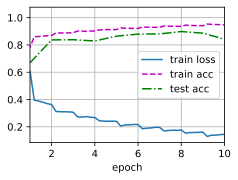

In [54]:
d2l.train_ch6(lenet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Batchnorm from scratch

In [55]:
def BatchNorm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean)/ torch.sqrt(moving_var + eps)
    else :
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else :
            mean = X.mean(dim=(0,2,3), keepdim=True)
            var = ((X-mean)**2).mean(dim=(0,2,3), keepdim=True)
        X_hat = (X - mean)/ torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum)* mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data
        
        

In [57]:
class BatchNormLayer(nn.Module):
    def __init__(self,num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1, num_features, 1,1)
        
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = BatchNorm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5,momentum=0.9)
        return Y

In [60]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNormLayer(6, num_dims=4),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16,
    kernel_size=5), BatchNormLayer(16, num_dims=4),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(7056, 120),
    BatchNormLayer(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNormLayer(84, num_dims=2),
    nn.Sigmoid(), nn.Linear(84, 10))

In [61]:
look_in_net(net, X)

Conv2d : torch.Size([256, 6, 92, 92])
BatchNormLayer : torch.Size([256, 6, 92, 92])
Sigmoid : torch.Size([256, 6, 92, 92])
AvgPool2d : torch.Size([256, 6, 46, 46])
Conv2d : torch.Size([256, 16, 42, 42])
BatchNormLayer : torch.Size([256, 16, 42, 42])
Sigmoid : torch.Size([256, 16, 42, 42])
AvgPool2d : torch.Size([256, 16, 21, 21])
Flatten : torch.Size([256, 7056])
Linear : torch.Size([256, 120])
BatchNormLayer : torch.Size([256, 120])
Sigmoid : torch.Size([256, 120])
Linear : torch.Size([256, 84])
BatchNormLayer : torch.Size([256, 84])
Sigmoid : torch.Size([256, 84])
Linear : torch.Size([256, 10])


In [6]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

In [7]:
def train_net(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.110, train acc 0.962, test acc 0.886
3612.6 examples/sec on cuda:0


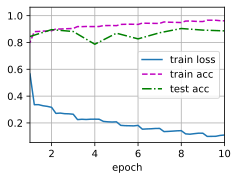

In [64]:
train_net(lenet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Exercises

1. Can we remove the bias parameter from the fully-connected layer or the convolutional layer
before the batch normalization? Why?

* Since batchnorm already includes bias, and also shift by mean any constant would be cancelled out therefore, it makes no sense to add bias.

2. Compare the learning rates for LeNet with and without batch normalization.

1. Plot the increase in training and test accuracy.
    * with batchnorm the accuracy = 0.962 at lr 1.0
    * without batchnorm the accuracy 0.931 at lr 0.1
2. How large can you make the learning rate?
    * tried with 1.0
3. Do we need batch normalization in every layer? Experiment with it?
    * okay. tried it is surprisingly giving accuracy of 94.6
4. Can you replace dropout by batch normalization? How does the behavior change?

    * from https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout 
       ```  
         193

    In the Ioffe and Szegedy 2015, the authors state that "we would like to ensure that for any parameter values, the network always produces activations with the desired distribution". So the Batch Normalization Layer is actually inserted right after a Conv Layer/Fully Connected Layer, but before feeding into ReLu (or any other kinds of) activation. See this video at around time 53 min for more details.

    As far as dropout goes, I believe dropout is applied after activation layer. In the dropout paper figure 3b, the dropout factor/probability matrix r(l) for hidden layer l is applied to it on y(l), where y(l) is the result after applying activation function f.

    So in summary, the order of using batch normalization and dropout is:

    -> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
    ```
    
5. Fix the parameters beta and gamma, and observe and analyze the results.

    * okay
    
6. Review the online documentation for BatchNorm from the high-level APIs to see the other
applications for batch normalization.

https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

https://arxiv.org/abs/1502.03167

``Our method draws its strength from making normalization a part of the model architecture and performing the
normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and
be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout.
Applied to a state-of-the-art image classification model,
Batch Normalization achieves the same accuracy with 14
times fewer training steps, and beats the original model
by a significant margin.```

7. Research ideas: think of other normalization transforms that you can apply?

Can you apply the probability integral transform? 

- https://en.wikipedia.org/wiki/Probability_integral_transform

in probability theory, the probability integral transform (also known as universality of the uniform) relates to the result that data values that are modeled as being random variables from any given continuous distribution can be converted to random variables having a standard uniform distribution.[1] This holds exactly provided that the distribution being used is the true distribution of the random variables; if the distribution is one fitted to the data, the result will hold approximately in large samples.


How about a full rank covariance estimate?

- did not get it



In [65]:
#2
lenet_wbn = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
        
                    nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(7056, 120),
    
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

In [66]:
look_in_net(lenet_wbn, X)

Conv2d : torch.Size([256, 6, 92, 92])
Sigmoid : torch.Size([256, 6, 92, 92])
MaxPool2d : torch.Size([256, 6, 46, 46])
Conv2d : torch.Size([256, 16, 42, 42])
Sigmoid : torch.Size([256, 16, 42, 42])
MaxPool2d : torch.Size([256, 16, 21, 21])
Flatten : torch.Size([256, 7056])
Linear : torch.Size([256, 120])
Sigmoid : torch.Size([256, 120])
Linear : torch.Size([256, 84])
Sigmoid : torch.Size([256, 84])
Linear : torch.Size([256, 10])


loss 0.197, train acc 0.931, test acc 0.807
3649.5 examples/sec on cuda:0


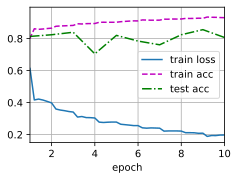

In [67]:
train_net(lenet, train_iter, test_iter, num_epochs, 0.1, d2l.try_gpu())

In [70]:
#2
lenet_bn = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),nn.BatchNorm2d(6),
                    nn.Sigmoid(),nn.BatchNorm2d(6),
                    nn.MaxPool2d(kernel_size=2, stride=2),nn.BatchNorm2d(6),
                    nn.Conv2d(6, 16, kernel_size=5),nn.BatchNorm2d(16),
        
                    nn.Sigmoid(),nn.BatchNorm2d(16),
                    nn.MaxPool2d(kernel_size=2, stride=2),nn.BatchNorm2d(16),
                    nn.Flatten(),nn.BatchNorm1d(7056),
                    nn.Linear(7056, 120),nn.BatchNorm1d(120),
    
                    nn.Sigmoid(),nn.BatchNorm1d(120),
                    nn.Linear(120, 84),nn.BatchNorm1d(84),
                
                    nn.Sigmoid(),nn.BatchNorm1d(84),
                    nn.Linear(84, 10))

In [71]:
look_in_net(lenet_bn, X)

Conv2d : torch.Size([256, 6, 92, 92])
BatchNorm2d : torch.Size([256, 6, 92, 92])
Sigmoid : torch.Size([256, 6, 92, 92])
BatchNorm2d : torch.Size([256, 6, 92, 92])
MaxPool2d : torch.Size([256, 6, 46, 46])
BatchNorm2d : torch.Size([256, 6, 46, 46])
Conv2d : torch.Size([256, 16, 42, 42])
BatchNorm2d : torch.Size([256, 16, 42, 42])
Sigmoid : torch.Size([256, 16, 42, 42])
BatchNorm2d : torch.Size([256, 16, 42, 42])
MaxPool2d : torch.Size([256, 16, 21, 21])
BatchNorm2d : torch.Size([256, 16, 21, 21])
Flatten : torch.Size([256, 7056])
BatchNorm1d : torch.Size([256, 7056])
Linear : torch.Size([256, 120])
BatchNorm1d : torch.Size([256, 120])
Sigmoid : torch.Size([256, 120])
BatchNorm1d : torch.Size([256, 120])
Linear : torch.Size([256, 84])
BatchNorm1d : torch.Size([256, 84])
Sigmoid : torch.Size([256, 84])
BatchNorm1d : torch.Size([256, 84])
Linear : torch.Size([256, 10])


loss 0.161, train acc 0.946, test acc 0.900
3632.7 examples/sec on cuda:0


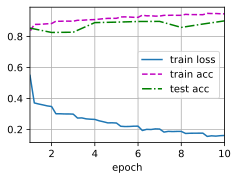

In [72]:
train_net(lenet, train_iter, test_iter, num_epochs, 0.1, d2l.try_gpu())

In [11]:
#5 fixing parameters

def BatchNorm_fixed(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean)/ torch.sqrt(moving_var + eps)
    else :
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else :
            mean = X.mean(dim=(0,2,3), keepdim=True)
            var = ((X-mean)**2).mean(dim=(0,2,3), keepdim=True)
        X_hat = (X - mean)/ torch.sqrt(var + eps)
        #moving_mean = momentum * moving_mean + (1.0 - momentum)* mean
        #moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y
        
        

In [12]:
class BatchNormLayer_fixed(nn.Module):
    def __init__(self,num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1, num_features, 1,1)
        
        self.gamma = nn.Parameter(torch.randn(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y = BatchNorm_fixed(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5,momentum=0.9)
        return Y

In [13]:
net_fixed = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNormLayer_fixed(6, num_dims=4),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16,
    kernel_size=5), BatchNormLayer_fixed(16, num_dims=4),
    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(7056, 120),
    BatchNormLayer_fixed(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNormLayer_fixed(84, num_dims=2),
    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.268, train acc 0.905, test acc 0.100
1757.5 examples/sec on cuda:0


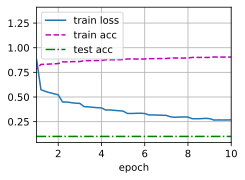

In [14]:
train_net(net_fixed, train_iter, test_iter, num_epochs, 0.1, d2l.try_gpu())